# Imports

In [1]:
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
%matplotlib inline
import pickle
import gensim.downloader as api
import random

# Data Loading

In [ ]:
!wget https://www.dropbox.com/s/dtefs3trz9b0e3p/X_raw_full_jsonlines.csv?dl=0

In [79]:
p = 0.50  # 50% of the lines

X_reviews = pd.read_csv(
         "./X_raw_full_jsonlines.csv",
         header=0, 
         skiprows=lambda i: i>0 and random.random() > p
)

In [ ]:
# X_reviews = pd.read_csv("./X_raw_full_jsonlines.csv", nrows=10_000)

In [80]:
X_reviews["is_movie"].value_counts()

1    26015
0     4614
Name: is_movie, dtype: int64

In [5]:
X_reviews.head()

,item_id,txt,is_movie
0,6,One of the best films of the 90's; I am assumi...,1
1,9,"Review of Sudden Death; OK, let's be straight ...",1
2,13,Balto is an excellent movie about a dog who wa...,1
3,16,Casino: the funniest movie ever made; I've see...,1
4,17,"Wonderful, beautiful movie; This would have to...",1


# Bert embedding


In [ ]:
!pip install sentence-transformers==2.2.2

In [7]:
from sklearn.cluster import AgglomerativeClustering
from sentence_transformers import SentenceTransformer # Make sure you have done a "pip install -e ." to have SentenceTransformer package installed

In [ ]:
bert = SentenceTransformer('all-MiniLM-L6-v2')

In [81]:
bert_embeddings = bert.encode(X_reviews["txt"])
np.shape(bert_embeddings)

(30629, 384)

# Agglomerative clustering

In [10]:
N_CLUSTER = 2_500

In [82]:
clustering_bert = AgglomerativeClustering(n_clusters=N_CLUSTER).fit(bert_embeddings)

In [83]:
X_reviews["clustering_label_bert"] = clustering_bert.labels_

# Loading metadata

In [84]:
metadata_movies = pd.read_json("./data/raw_data/raw_movies/metadata.json", lines=True)
metadata_books = pd.read_json("./data/raw_data/raw_book/metadata.json", lines=True)

In [85]:
metadata_movies.rename({"title":"movie_title"}, axis='columns',inplace=True)
metadata_books.rename({"title":"book_title"}, axis='columns',inplace=True)

In [86]:
merged_movies_complete = pd.merge(X_reviews, metadata_movies, on="item_id", how="left")
merged_all_bert = pd.merge(merged_movies_complete, metadata_books, on="item_id", how="left")

In [87]:
tag_movies = pd.read_json("./data/raw_data/raw_movies/tags.json", lines=True)
tag_count_movies = pd.read_json("./data/raw_data/raw_movies/tag_count.json", lines=True)
tag_books = pd.read_json("./data/raw_data/raw_book/tags.json", lines=True)
tag_count_book = pd.read_json("./data/raw_data/raw_book/tag_count.json", lines=True)

In [88]:
tag_movies_final = pd.merge(tag_movies, tag_count_movies, left_on="id", right_on="tag_id", how="left")

In [89]:
tag_movies_final.drop(columns=["id", "tag_id"], inplace=True)

In [90]:
tag_book_final = pd.merge(tag_books, tag_count_book, left_on="id", right_on="tag_id", how="left")

In [91]:
tag_book_final.drop(columns=["id", "tag_id"], inplace=True)

In [92]:
tags = pd.concat([tag_movies_final, tag_book_final])

In [93]:
tags.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 451956 entries, 0 to 239251
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   tag      451956 non-null  object
 1   item_id  451956 non-null  int64 
 2   num      451956 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 13.8+ MB


In [94]:
items_and_tags = pd.merge(merged_all_bert, tags, how="left", on="item_id")

In [ ]:
items_and_tags.info()

In [96]:
clustered = items_and_tags[["movie_title","book_title","clustering_label_bert","is_movie", "item_id", "txt", "tag", "num"]]
clustered = clustered.fillna("")

In [97]:
clustered = merged_all_bert[["movie_title","book_title","clustering_label_bert","is_movie", "item_id", "txt"]]
clustered = clustered.fillna("")

# **Cluster** **Visualization**

In [103]:
df = clustered[clustered["clustering_label_bert"] == 1147][["book_title", "movie_title", "txt"]]

In [104]:
df

,book_title,movie_title,txt
2415,,Harry Potter and the Sorcerer's Stone (a.k.a. ...,Good Family Fantasy; In the first outing for H...
2881,,Harry Potter and the Chamber of Secrets (2002),A good follow up to Potters first outing; With...
6021,,Harry Potter and the Order of the Phoenix (2007),Harry Potter Back in Hogwarts; Harry comes bac...
9276,,"Woman in Black, The (2012)",A lot like Dead Silence meets Insidious.; The ...
9291,,My Boy Jack (2007),Thought provoking hopeless tragedy; I found hi...
16160,,Fantastic Beasts and Where to Find Them (2016),"Magical, Mischievous and Wicked; Perhaps the b..."
21997,,Imperium (2016),was this written by a 3rd grader; This movie w...
29427,"The Copper Gauntlet (Magisterium, #2)",,See full review for The Copper Gauntlet at: ht...
29902,"The Novice (Summoner, #1)",,"Well, how can it tortures me with this kind of..."


In [47]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

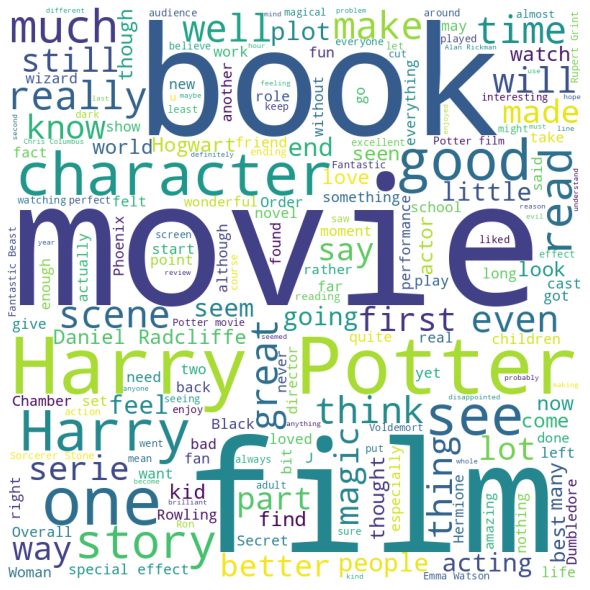

In [105]:
wordcloud = WordCloud(width = 800, height = 800, background_color ='white', min_font_size = 10).generate(','.join(df["txt"].values))

plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

In [40]:
df[["movie_title", "book_title"]].value_counts()

movie_title                                     book_title                             
Harry Potter and the Chamber of Secrets (2002)                                             28
                                                Fade Out (The Morganville Vampires, #7)    20
dtype: int64

In [102]:
clustered[clustered["movie_title"].str.contains("potter", case=False)]["clustering_label_bert"].value_counts()

1147    3
1171    1
2424    1
1073    1
1506    1
Name: clustering_label_bert, dtype: int64